# GauOptX: external objective function evaluation

GauOptX allows to evaluate objective function externally. If users opt for this approach, they can use GauOptX to suggest next point for evaluation, and then evaluate the objective function themselves as well as decide on the stopping criteria of the evaluation loop.

For the purposes of this notebook we are going to use one of the predefined objective functions that come with GauOptX. However the key thing to realize is that the function could be anything (e.g., the results of a physical experiment). As long as users are able to externally evaluate the suggested points somehow and provide GauOptX with results, the library has opinions about the objective function's origin.

In [2]:
func = GauOptX.objective_examples.experiments1d.forrester() 

Now we define the domain of the function to optimize as usual.

In [3]:
domain =[{'name': 'var1', 'type': 'continuous', 'domain': (0,1)}]

First we are going to run the optimization loop outside of GauOptX, and only use GauOptX to get the next point to evaluate our function.

There are two thing to pay attention to when creating the main optimization object:
* Objective function f is explicitly set to None.
* Since we recreate the object anew for each iteration, we need to pass data about all previous iterations to it.

In [4]:
X_init = np.array([[0.0],[0.5],[1.0]])
Y_init = func.f(X_init)

iter_count = 10
current_iter = 0
X_step = X_init
Y_step = Y_init

while current_iter < iter_count:
    bo_step = GauOptX.methods.BayesianOptimization(f = None, domain = domain, X = X_step, Y = Y_step)
    x_next = bo_step.suggest_next_locations()
    y_next = func.f(x_next)
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    
    current_iter += 1

Let's visualize the results. The size of the marker denotes the order in which the point was evaluated - the bigger the marker the later was the evaluation.

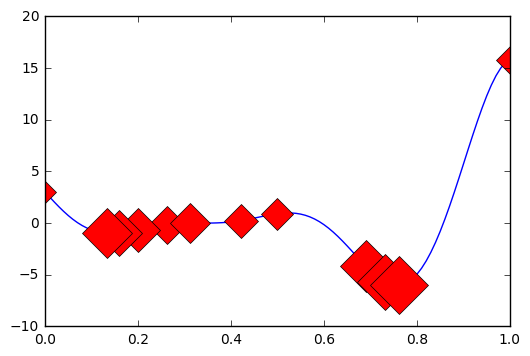

In [5]:
x = np.arange(0.0, 1.0, 0.01)
y = func.f(x)

plt.figure()
plt.plot(x, y)
for i, (xs, ys) in enumerate(zip(X_step, Y_step)):
    plt.plot(xs, ys, 'rD', markersize=10 + 20 * (i+1)/len(X_step))

To compare the results, let's now execute the whole loop with GauOptX.

In [6]:
bo_loop = GauOptX.methods.BayesianOptimization(f = func.f, domain = domain, X = X_init, Y = Y_init)
bo_loop.run_optimization(max_iter=iter_count)
X_loop = bo_loop.X
Y_loop = bo_loop.Y

Now let's print the results of this optimization and compare to the previous external evaluation run. As before, size of the marker corresponds to its evaluation order.

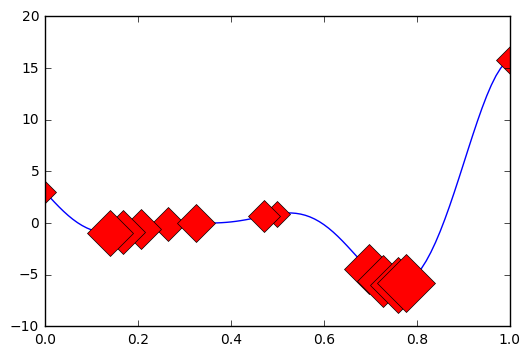

In [7]:
plt.figure()
plt.plot(x, y)
for i, (xl, yl) in enumerate(zip(X_loop, Y_loop)):
    plt.plot(xl, yl, 'rD', markersize=10 + 20 * (i+1)/len(X_step))

To allow even more control over the execution, this API allows to specify points that should be ignored (say the objetive is known to fail in certain locations), as well as points that are already pending evaluation (say in case the user is running several candidates in parallel). Here is how one can provide this information.

In [8]:
pending_X = np.array([[0.75]])
ignored_X = np.array([[0.15], [0.85]])
bo = GauOptX.methods.BayesianOptimization(f = None, domain = domain, X = X_step, Y = Y_step, de_duplication = True)
bo.suggest_next_locations(pending_X = pending_X, ignored_X = ignored_X)

array([[ 0.78428913]])

Few things to note here:
* It is required to set `de_duplication` flag of the optimization object to `True` to enable treatment of pending and ignored locations.
* At the moment library treats ignored and pending the same way - does not suggest them as candidates. There are plans to leverage their semantic difference to further optimize the library's behavior.